In [6]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax


In [7]:
from policy.policy_training import DPCTrainer,data_generation
from exciting_environments.pmsm.pmsm_env import PMSM
from policy.networks import MLP,MLP2

In [8]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

In [9]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[])


In [10]:
@eqx.filter_jit
def motor_env_dat_gen_sin(env, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs, _ = env.reset(env.env_properties, subkey)  #
    rng, subkey = jax.random.split(rng)
    init_obs, _ = env.reset(env.env_properties, subkey)  #
    init_obs = init_obs.at[2].set((3000 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))

    return init_obs, ref_obs, rng

In [11]:
@eqx.filter_jit
def featurize(obs,ref_obs):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2]])
    return feat_obs

In [12]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([6,64,64,64,2], key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

In [13]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,-2:])**2,axis=1))
    return loss

In [14]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    loss=jnp.array([0])
    return loss

In [15]:
data_batch_size=50
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=6000,
    horizon_length=200,
    data_gen_sin=motor_env_dat_gen_sin,
    featurize=featurize,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

In [11]:
fin_policy,fin_opt_state,fin_keys,losses=trainer.fit_non_jit(policy,motor_env,keys,opt_state)

  1%|          | 56/6000 [00:29<53:03,  1.87it/s]  


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.yscale('log')

NameError: name 'losses' is not defined

## Evaluate

In [85]:
obs, _= motor_env.reset(env_properties=motor_env.env_properties,rng=jax.random.PRNGKey(np.random.randint(0, 2**31))) #
obs_ref, _ = motor_env.reset(env_properties=motor_env.env_properties,rng=jax.random.PRNGKey(np.random.randint(0, 2**31))) #
next_obs=obs
next_obs=next_obs.at[2].set((3000 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
next_state=motor_env.generate_state_from_observation(next_obs,env_properties=motor_env.env_properties)
i_dqs=[]
i_dqs.append(next_obs[0:2])
acts=[]
for _ in range(1000):
    feat_obs=featurize(next_obs,obs_ref)
    act=fin_policy(feat_obs)
    next_obs, next_state = motor_env.step(next_state, act, motor_env.env_properties)
    i_dqs.append(next_obs[0:2])
    acts.append(act)

Text(0, 0.5, 'i_q')

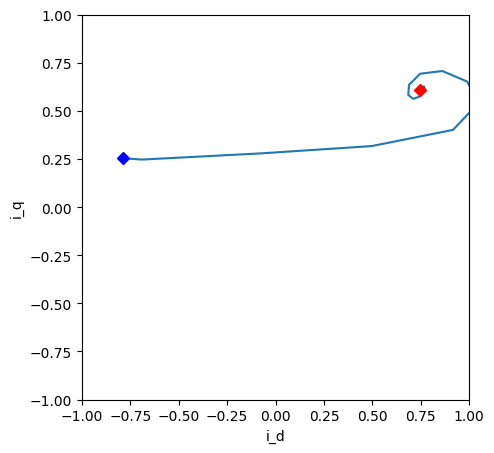

In [86]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1]) #,label="currents"
ax.plot((obs_ref)[0],(obs_ref)[1],color="r",marker='D')
ax.plot((obs)[0],(obs)[1],color="b",marker='D')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")

In [56]:
def steps_ref_traj(env, rng,num_steps, step_lens=[100,400]):
    #TODO write jittable
    key=rng
    traj, _ = env.reset(env.env_properties)
    traj=traj[:,None]
    for _ in range(num_steps):
        key, subkey = jax.random.split(key)
        ref_ob, _ = env.reset(env.env_properties, subkey)
        key, subkey = jax.random.split(key)
        len=jax.random.randint(key,shape=(1,),minval=step_lens[0],maxval=step_lens[1])
        k=jnp.concatenate([jnp.ones(len),jnp.zeros(step_lens[1]-len)],axis=0)
        traj_step=jnp.repeat(ref_ob[:,None],step_lens[1],axis=1)*k
        traj=jnp.concatenate([traj,traj_step],axis=1)

    
    return traj.T

In [57]:
steps_ref_traj(motor_env, jax.random.PRNGKey(np.random.randint(0, 2**31)),10).shape

(4001, 8)

In [58]:
def steps_ref_traj2(env, rng,num_steps, horizon_len):
    
    lens,key=generate_n_random_numbers_with_sum_M(rng,num_steps,horizon_len)

    traj, _ = env.reset(env.env_properties)
    traj=jnp.empty_like(traj)[:,None]

    init_carry=(traj,key)

    def body_fun(carry, len):
        traj,key=carry
        key, subkey = jax.random.split(key)
        ref_ob, _ = env.reset(env.env_properties, subkey)
        traj_step=jnp.repeat(ref_ob[:,None],num_steps,axis=1)
        k=jnp.concatenate([jnp.ones(len),jnp.zeros(step_lens[1]-len)],axis=0)
        traj_step[:len]=0
        traj=jnp.concatenate([traj,traj_step],axis=1)
       

        return (traj, key),(_, _)

    (traj_fin, key_fin), _ = jax.lax.scan(body_fun, init_carry, lens, len(lens))
    
    return traj_fin, key_fin

In [77]:
def fun(len,env,key,step_lens=[100,400]):
    key, subkey = jax.random.split(key)
    ref_ob, _ = env.reset(env.env_properties, subkey)
    traj_step=jnp.repeat(ref_ob[:,None],step_lens[1],axis=1)
    k=jnp.concatenate([jnp.ones(len),jnp.nan*jnp.ones(step_lens[1]-len)],axis=0)
    
    return k*traj_step

In [78]:
fun(10,motor_env,jax.random.PRNGKey(np.random.randint(0, 2**31)))

Array([[ 0.88162786,  0.88162786,  0.88162786, ...,         nan,
                nan,         nan],
       [-0.49886945, -0.49886945, -0.49886945, ...,         nan,
                nan,         nan],
       [ 0.15093185,  0.15093185,  0.15093185, ...,         nan,
                nan,         nan],
       ...,
       [-0.6151885 , -0.6151885 , -0.6151885 , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan]], dtype=float32)

In [ ]:
def ref(env, key, ref_len, step_lens=[100,400]):
    t = 0
    ref = []
            
        key, subkey = jax.random.split(key)
        len=jax.random.randint(key,shape=(1,),minval=step_lens[0],maxval=step_lens[1])
        k=jnp.concatenate([jnp.ones(len),jnp.zeros(step_lens[1]-len)],axis=0)
        traj_step=jnp.repeat(ref_ob[:,None],step_lens[1],axis=1)*k
        traj=jnp.concatenate([traj,traj_step],axis=1)
    
    while ref < ref_len:
        key, subkey1, subkey2 = jax.random.split(key, num=2)
        ref_obs, _ = env.reset(env.env_properties, subkey1)

        t_step = jax.random.randint(subkey2, shape=(1,), minval=step_lens[0], maxval=step_lens[1])

        ref.append(jnp.ones(t_step) * ref_obs[None,:])
        t += t_step.item()

    return jnp.hstack(sig)[:len]

In [74]:
lens,key=generate_random_numbers(jax.random.PRNGKey(np.random.randint(0, 2**31)),5,100)

In [79]:
keys=jax.random.split(key,num=len(lens))

In [80]:
jax.vmap(fun,in_axes=(0,None,0))(lens,motor_env,keys)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([53,  4,  8, 17, 18], dtype=int32)
  batch_dim = 0,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
This BatchTracer with object id 140509997713904 was created on line:
  /tmp/ipykernel_3808187/1911609451.py:1 (<module>)

In [59]:
steps_ref_traj2(motor_env, jax.random.PRNGKey(np.random.randint(0, 2**31)),10,1000)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function body_fun at /tmp/ipykernel_3808187/49527127.py:10 for scan. This concrete value was not available in Python because it depends on the value of the argument len.

In [19]:
steps_ref_traj(motor_env, jax.random.PRNGKey(np.random.randint(0, 2**31)),20)

IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(None, Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=1/0)>, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

In [90]:
obs, _= motor_env.reset(env_properties=motor_env.env_properties) #
obs_ref = steps_ref_traj(motor_env, jax.random.PRNGKey(np.random.randint(0, 2**31)),20)
next_obs=obs.at[2].set((3000 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
next_state=motor_env.generate_state_from_observation(next_obs,env_properties=motor_env.env_properties)
i_dqs=[]
#i_dqs.append(next_obs[0:2])
acts=[]
for i in range(obs_ref.shape[0]):
    feat_obs=featurize(next_obs,obs_ref[i])
    act=fin_policy(feat_obs)
    next_obs, next_state = motor_env.step(next_state, act, motor_env.env_properties)
    i_dqs.append(next_obs[0:2])
    acts.append(act)

In [118]:
len(jnp.array([[2,5,6],[2,5,6]]).shape)

2

In [151]:
observ,action=rollout_changing_traj_env(fin_policy,obs.at[2].set((3000 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60)),obs_ref[0],obs_ref.shape[0],motor_env,featurize)

In [140]:
observ.shape

(5012, 8)

Text(0, 0.5, 'i_q')

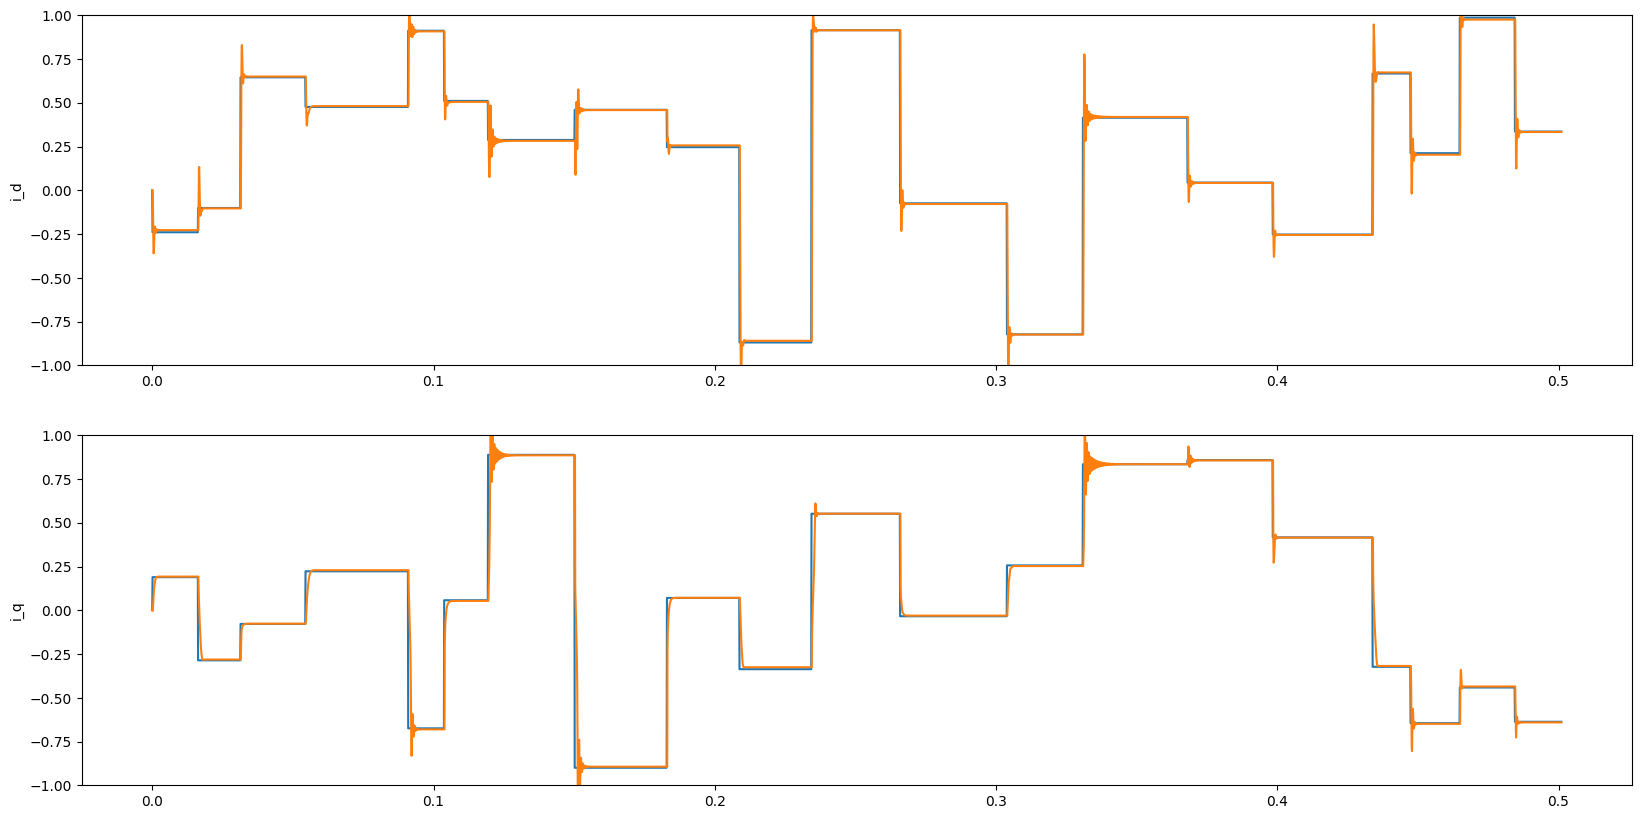

In [116]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(2,1,figsize=(20,10))
time=jnp.linspace(0,obs_ref.shape[0]-1,obs_ref.shape[0])*motor_env.tau
ax[0].plot(time,obs_ref[:,0]) #,label="currents"
ax[0].plot(time,observ[:-1,0]) #,label="currents"
ax[1].plot(time,obs_ref[:,1]) #,label="currents"
ax[1].plot(time,observ[:-1,1]) #,label="currents"
ax[1].set_ylim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_ylabel("i_d")
ax[1].set_ylabel("i_q")

Text(0, 0.5, 'i_q')

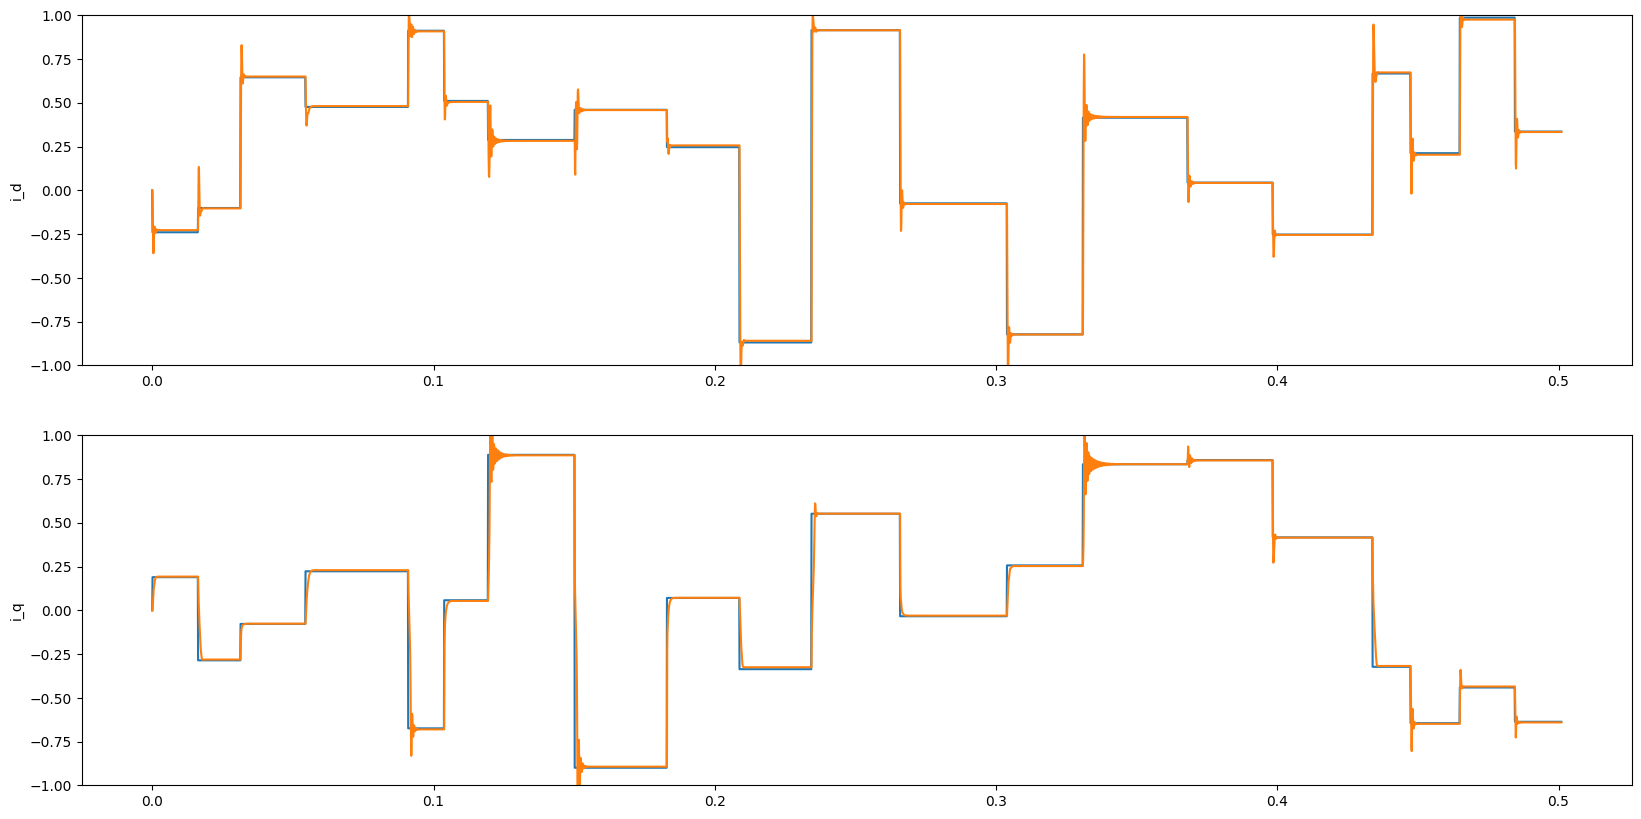

In [108]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(2,1,figsize=(20,10))
time=jnp.linspace(0,obs_ref.shape[0]-1,obs_ref.shape[0])*motor_env.tau
ax[0].plot(time,obs_ref[:,0]) #,label="currents"
ax[0].plot(time,jnp.array(i_dqs)[:,0]) #,label="currents"
ax[1].plot(time,obs_ref[:,1]) #,label="currents"
ax[1].plot(time,jnp.array(i_dqs)[:,1]) #,label="currents"
ax[1].set_ylim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_ylabel("i_d")
ax[1].set_ylabel("i_q")

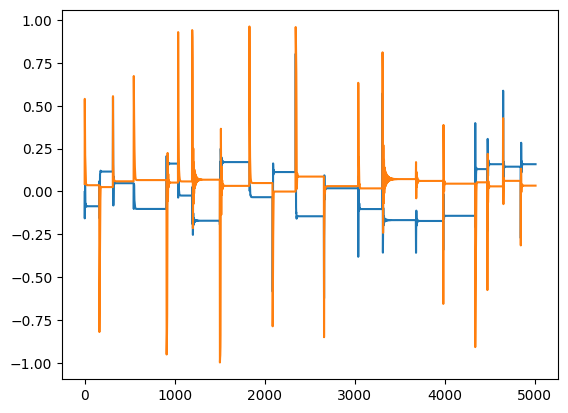

In [94]:
plt.plot(acts)

In [183]:
import random

def generate_random_numbers(n, M):
    # Generate n-1 random "cut points" between 0 and M, sort them
    cuts = sorted([random.randint(1, M-1) for _ in range(n-1)])
    print(cuts)
    # Create the list of numbers by taking differences between the cut points
    numbers = [cuts[0]] + [cuts[i] - cuts[i-1] for i in range(1, n-1)] + [M - cuts[-1]]
    
    return numbers

# Example usage:
n = 5  # Number of integers
M = 35  # Desired sum
random_numbers = generate_random_numbers(n, M)
print("Random numbers:", random_numbers)
print("Sum:", sum(random_numbers))  # Should equal M

[11, 13, 14, 33]
Random numbers: [11, 2, 1, 19, 2]
Sum: 35


In [130]:
numbers = [cuts[0]] + [cuts[1:5-1]-cuts[0:5-2]] + [35 - cuts[-1]]

In [135]:
numbers

[Array(9, dtype=int32),
 Array([ 3, 18,  2], dtype=int32),
 Array(3, dtype=int32)]

In [197]:
@eqx.filter_jit
def generate_random_numbers(key,n, M):

    key, subkey=jax.random.split(key)
    
    # Generate n-1 random "cut points" between 0 and M, sort them
    cuts= jnp.sort(jax.random.randint(subkey,shape=((n-1),),minval=1,maxval=M-1))

    # Create the list of numbers by taking differences between the cut points
    numbers = jnp.concatenate([cuts[0][None],(cuts[1:n-1]-cuts[0:n-2]) , (M - cuts[-1][None])])
    return numbers, key

In [206]:
# Example usage:
key=jax.random.key(9)
n =  15 # Number of integers
M = 10000  # Desired sum
random_numbers = generate_random_numbers(key,n, M)
print("Random numbers:", random_numbers)
print("Sum:", sum(random_numbers))  # Should equal M

Random numbers: [1935   61  308  176  663   12  129  616  171 1461  243 1409  652 1727
  437]
Sum: 10000
